### **Load Library**

In [1]:
from google.colab import drive

# Mount Google-Drive Directory
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from scipy import stats
from google.colab import userdata
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
FOLDER_PATH = userdata.get("FOLDER_PATH")
%cd $FOLDER_PATH

/content/gdrive/MyDrive/AI Models/SupervisedLearning/regression-crop-yield


### **Load Dataset**

In [3]:
# Load data from kaggle
def pandas_df(path: str, file_name: str) -> pd.DataFrame:

    path = os.path.join(path, f"{file_name}")

    return pd.read_csv(path)


In [4]:
# Load processed data
FILE_NAME = "processed/crop_yield_dataset.csv"
df = pandas_df(FOLDER_PATH, FILE_NAME)
df.head()

,region,soil_type,crop,rainfall_mm,temperature_celsius,fertilizer_used,irrigation_used,weather_condition,days_to_harvest,yield_success,crop_yield
0,west,sandy,cotton,897.077239,27.676966,no,yes,cloudy,122,yes,6.555816
1,south,clay,rice,992.673282,18.026142,yes,yes,rainy,140,yes,8.527341
2,north,loam,barley,147.998025,29.794042,no,no,sunny,106,yes,1.127443
3,north,sandy,soybean,986.866331,16.644190,no,yes,rainy,146,yes,6.517573
4,south,silt,wheat,730.379174,31.620687,yes,yes,cloudy,110,yes,7.248251


### **Model Implementation**

In [5]:
pandas_df = df.copy()
print(f"We have {pandas_df.shape[0]} records in our source dataset")

# split target variable into it's own dataset
target_col = "crop_yield"
X_all = pandas_df.drop(labels=target_col, axis=1)
y_all = pandas_df[target_col]

We have 1000000 records in our source dataset


#### **Train/Test Split**

In [6]:
# test / train split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=42)
print(f"We have {X_train.shape[0]} records in our training dataset")
print(f"We have {X_test.shape[0]} records in our test dataset")

We have 800000 records in our training dataset
We have 200000 records in our test dataset


#### **Feature Encoding & Scaling**

In [7]:
# Select Columns
categorical_X_cols = X_train.select_dtypes("object").columns
numerical_X_cols = X_train.select_dtypes("number").columns

# Encoding & Scaling
sc = StandardScaler()
oh = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

X_train_ = X_train.copy()
# Feature Scaling
for c in numerical_X_cols:
    X_train_[c] = sc.fit_transform(X_train_[[c]]).ravel()

# Feature Encodings
for c in categorical_X_cols:
    cat_feature = oh.fit_transform(X_train_[[c]])
    X_train_ = pd.concat([X_train_, cat_feature], axis=1)
    X_train_.drop(columns=[c], inplace=True)

X_train_  = X_train_.reset_index(drop=True)

In [8]:
X_train_.head()

,rainfall_mm,temperature_celsius,days_to_harvest,region_east,region_north,region_south,region_west,soil_type_chalky,soil_type_clay,soil_type_loam,...,crop_wheat,fertilizer_used_no,fertilizer_used_yes,irrigation_used_no,irrigation_used_yes,weather_condition_cloudy,weather_condition_rainy,weather_condition_sunny,yield_success_no,yield_success_yes
0,1.299211,0.767268,-0.980873,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,-1.426747,-0.389472,-0.634162,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.382829,0.352719,0.598590,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.263925,-1.108459,-0.133356,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.720423,-1.285003,-0.634162,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


#### **Feature Selection**

In [13]:
from sklearn.feature_selection import SelectPercentile, r_regression, mutual_info_regression

select_X = SelectPercentile(mutual_info_regression, percentile=25)

X_train_best = select_X.fit_transform(X_train_, y_train)
selected_features = X_train_.columns[select_X.get_support(indices=True)]

In [29]:
# X_train_[selected_features]

#### **Model Selection**

In [10]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

sc = StandardScaler()
oh = OneHotEncoder(sparse_output=False)
baseline = DecisionTreeRegressor()

# target scaling
y_train_ = sc.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_ = sc.transform(y_test.values.reshape(-1, 1)).ravel()

# Pipeline Implementation
ct = make_column_transformer(
    (sc, make_column_selector(dtype_include=np.number)),
    (oh, make_column_selector(dtype_include=object)),
    remainder='drop'
)

pipe_model = make_pipeline(ct, LinearRegression()) \
            .fit(X_train, y_train_)

In [32]:
from sklearn.base import BaseEstimator

# Model prediction function
def predict_batch_fn(model: BaseEstimator, X_value: pd.DataFrame) -> list:
    return list(model.predict(X_value))

# Batch predictions
train_pred = predict_batch_fn(pipe_model, X_train)
test_pred = predict_batch_fn(pipe_model, X_test)

In [33]:
# Calculating model metrics
def calculate_metrics(y_true: list, y_pred: list) -> dict:

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    metrics = dict(
        r2=r2, mse=mse,
        mae=mae, rmse=rmse
    )

    # Round into 3 decimal places
    metrics_rounded = {k: np.round(v, 3) \
        for k, v in metrics.items()
    }
    return metrics_rounded

train_scores = calculate_metrics(y_train_, train_pred)
test_scores = calculate_metrics(y_test_, test_pred)
# train_scores
test_scores

{'r2': 0.913, 'mse': 0.087, 'mae': 0.235, 'rmse': 0.295}

In [34]:
# Residual Error Analysis
def model_diagnostic_analysis(title: str, y_true: list, y_pred: list) -> None:
    _ , (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    plt.style.use("ggplot")

    residuals = y_true - y_pred

    # Residuals vs. Predicted values
    ax1.scatter(residuals, y_pred, alpha=0.7)
    ax1.axhline(y=0, color='b', linestyle='--', linewidth=2)
    ax1.set_title(f"({title}) Residuals vs Predicted Values")
    ax1.set_xlabel("Predicted Values")
    ax1.set_ylabel("Residuals")

    # Histogram of Residuals
    ax2.hist(residuals, bins=15, edgecolor='k', alpha=0.7, color='b')
    ax2.set_title(f"({title}) Histogram of Residuals")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

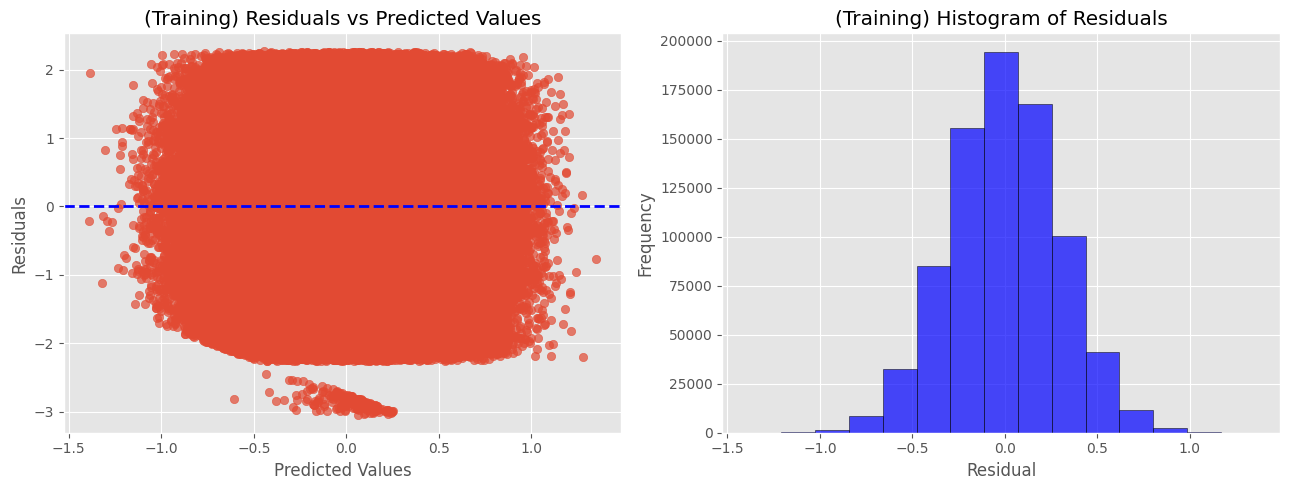

In [35]:
model_diagnostic_analysis("Training", y_train_, train_pred)

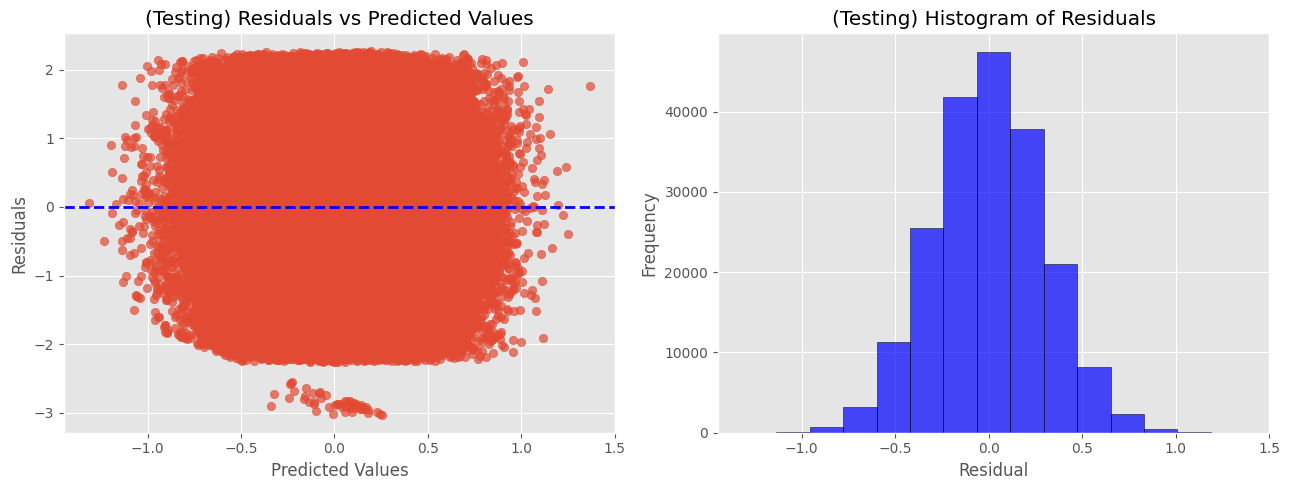

In [36]:
model_diagnostic_analysis("Testing", y_test_, test_pred)

In [37]:
# Cross-Validation
from sklearn.model_selection import KFold, cross_validate

ct = make_column_transformer(
    (sc, make_column_selector(dtype_include=np.number)),
    (oh, make_column_selector(dtype_include=object)),
    remainder='drop'
)

kf = KFold(n_splits=5, shuffle=True, random_state=43)

# K-Fold Cross-Validation
def custom_cross_validation(x_values: list) -> dict:

    r2_scores = []
    mse_scores = []
    mae_scores = []
    rmse_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(x_values)):

        X_train, X_val = x_values.iloc[train_idx], x_values.iloc[val_idx]
        y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        pipe = make_pipeline(ct, baseline) \
            .fit(X_train, y_train_fold)

        # Validate the model
        y_pred = pipe.predict(X_val)
        fold_mse = mean_squared_error(y_val, y_pred)
        fold_mae = mean_absolute_error(y_val, y_pred)
        fold_rmse = sqrt(fold_mse)
        fold_r2 = r2_score(y_val, y_pred)

        r2_scores.append(fold_r2)
        mse_scores.append(fold_mse)
        mae_scores.append(fold_mae)
        rmse_scores.append(fold_rmse)

    # Calculate the average scores across all folds
    fold_scores = dict(
        fold_r2=np.round(np.mean(r2_scores), 3),
        fold_mse= np.round(np.mean(mse_scores), 3),
        fold_rmse=  np.round(np.mean(rmse_scores), 3),
        fold_mae= np.round(np.mean(mae_scores), 3)
    )

    return fold_scores

custom_cross_validation(X_train_)


{'fold_r2': 0.816, 'fold_mse': 0.529, 'fold_rmse': 0.727, 'fold_mae': 0.581}

**Note:** Try to go learn about interpreting the model information provided above.